In [1]:
import torch
from torchvision import models, transforms
import traitlets
import ipywidgets.widgets as widgets
from IPython.display import display
from jetbot import Camera, bgr8_to_jpeg
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import math
from jetbot import Robot
import utils

robot = Robot()
camera = Camera.instance(width=300, height=300)
image = widgets.Image(format='jpeg', width=300, height=300)  # this width and height doesn't necessarily have to match the camera
camera_link = traitlets.dlink((camera, 'value'), (image, 'value'), transform=bgr8_to_jpeg)
display(image)

Succeeded to open the port
Succeeded to change the baudrate


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [15]:
# Model rozpoznawania podłogi
floor_prototype = np.load("../models/floor_prototype_full.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Usunięcie ostatniej warstwy
model = model.to(device)
model.eval()  # Tryb ewaluacji

# Parametry sterowania
FORWARD_SPEED = 1
TURN_SPEED = 1
DELAY = 0.1     # Czas odświeżania pętli w sekundach
MAP_SIZE = 300  # Rozmiar mapy
CELL_SIZE = 0.01  # 1 pixel = 0.01 m
ROBOT_SIZE = 0.2  # Rozmiar robota w metrach
VISION_RANGE = 0.2  # Jak daleko widzi robot (0.2m = 20 pikseli)
FORWARD_SPEED_MS = FORWARD_SPEED * 0.16  # Prędkość w metrach na sekundę
TURN_ANGLE = 30  # Robot skręca o 30 stopni przy losowym wyborze kierunku

# Inicjalizacja mapy (-1 = nieznane)
map_grid = np.full((MAP_SIZE, MAP_SIZE), -1)

# Pozycja początkowa robota w środku mapy
robot_x, robot_y = MAP_SIZE // 2, MAP_SIZE // 2
robot_direction = 0  # Kąt obrotu w stopniach (0 = góra)
last_move_time = time.time()  # Czas ostatniego ruchu do przodu
previous_move_was_forward = False  # Czy ostatni ruch był do przodu?


In [16]:
def move_and_print():
    global robot_direction, robot_x, robot_y, last_move_time, previous_move_was_forward
    try:
        print("Rozpoczęcie jazdy. Naciśnij Ctrl+C, aby zatrzymać.")
        has_turned = False  # Flaga: Czy robot ostatnio skręcał?
        turn_direction = None  # Kierunek ostatniego skrętu: 'left' lub 'right'

        while True:
            image = Image.fromarray(camera.value)
            forward_distance = utils.is_floor(image, model, device, floor_prototype)
            utils.update_map(forward_distance, robot_x, robot_y, robot_direction, map_grid)
            
            if previous_move_was_forward:
                current_time = time.time()
                time_elapsed = current_time - last_move_time
                last_move_time = current_time  # Aktualizacja ostatniego ruchu
                step_size = int((FORWARD_SPEED_MS * time_elapsed) / CELL_SIZE)
                # Obliczenie nowej pozycji robota
                angle_rad = np.radians(robot_direction)
                robot_x += int(step_size * np.cos(angle_rad))
                robot_y += int(step_size * np.sin(angle_rad))

            if forward_distance < 0.175: #and not utils.any_red_20_20(map_grid, robot_direction, robot_x, robot_y):  # Jeśli podłoga wykryta
                print(f"Podłoga wykryta. Jedź do przodu. Odległość: {forward_distance:.4f}")
                utils.move_forward(robot, FORWARD_SPEED)
                last_move_time = time.time()
                time.sleep(DELAY)  # Jedź chwilę do przodu
                has_turned = False
                turn_direction = None
                previous_move_was_forward = True
            else:
                print(f"Brak podłogi przed robotem. Odległość: {forward_distance:.4f}")
                previous_move_was_forward = False
                utils.stop(robot)
                if has_turned:
                    print(f"Kontynuowanie skrętu w kierunku: {turn_direction}")
                else:
                    # Rozejrzenie się i wybór najlepszego kierunku
                    print("Rozejrzenie się...")
                    utils.turn_by_angle(robot, -TURN_ANGLE/2, TURN_SPEED)  # Obrót w lewo o 15°
                    image = Image.fromarray(camera.value)
                    left_distance = utils.is_floor(image, model, device, floor_prototype)
                    utils.turn_by_angle(robot, TURN_ANGLE, TURN_SPEED)  # Obrót w prawo o 30° (15° w prawo od pozycji wyjściowej)
                    image = Image.fromarray(camera.value)
                    right_distance = utils.is_floor(image, model, device, floor_prototype)
                    # Powrót do pozycji początkowej (15° w lewo od pozycji prawej)
                    utils.turn_by_angle(robot, -TURN_ANGLE/2, TURN_SPEED)
                    # Wybór kierunku
                    if left_distance < right_distance:
                        print(f"Skręt w lewo o {TURN_ANGLE}°. Odległość w lewo: {left_distance:.4f}")
                        turn_direction = 'left'
                    else:
                        print(f"Skręt w prawo o {TURN_ANGLE}°. Odległość w prawo: {right_distance:.4f}")
                        turn_direction = 'right'
                    has_turned = True

                if turn_direction == 'left':
                    utils.turn_by_angle(robot, -TURN_ANGLE, TURN_SPEED)
                    robot_direction = (robot_direction - TURN_ANGLE) % 360
                elif turn_direction == 'right':
                    utils.turn_by_angle(robot, TURN_ANGLE, TURN_SPEED)
                    robot_direction = (right_distance + TURN_ANGLE) % 360

    except KeyboardInterrupt:
        print("Zatrzymano robota.")
    finally:
        utils.stop(robot)

    


In [17]:
move_and_print()

Rozpoczęcie jazdy. Naciśnij Ctrl+C, aby zatrzymać.
Podłoga wykryta. Jedź do przodu. Odległość: 0.1636
Podłoga wykryta. Jedź do przodu. Odległość: 0.1627
Podłoga wykryta. Jedź do przodu. Odległość: 0.1468
Podłoga wykryta. Jedź do przodu. Odległość: 0.1507
Brak podłogi przed robotem. Odległość: 0.1807
Rozejrzenie się...
Obrót o -15.0° zakończony w czasie 0.23 sekundy (prędkość: 1).
Obrót o 30° zakończony w czasie 0.47 sekundy (prędkość: 1).
Obrót o -15.0° zakończony w czasie 0.23 sekundy (prędkość: 1).
Skręt w lewo o 30°. Odległość w lewo: 0.1854
Obrót o -30° zakończony w czasie 0.47 sekundy (prędkość: 1).
Podłoga wykryta. Jedź do przodu. Odległość: 0.1738
Brak podłogi przed robotem. Odległość: 0.2072
Rozejrzenie się...
Obrót o -15.0° zakończony w czasie 0.23 sekundy (prędkość: 1).
Obrót o 30° zakończony w czasie 0.47 sekundy (prędkość: 1).
Obrót o -15.0° zakończony w czasie 0.23 sekundy (prędkość: 1).
Skręt w lewo o 30°. Odległość w lewo: 0.1904
Obrót o -30° zakończony w czasie 0.47 sek

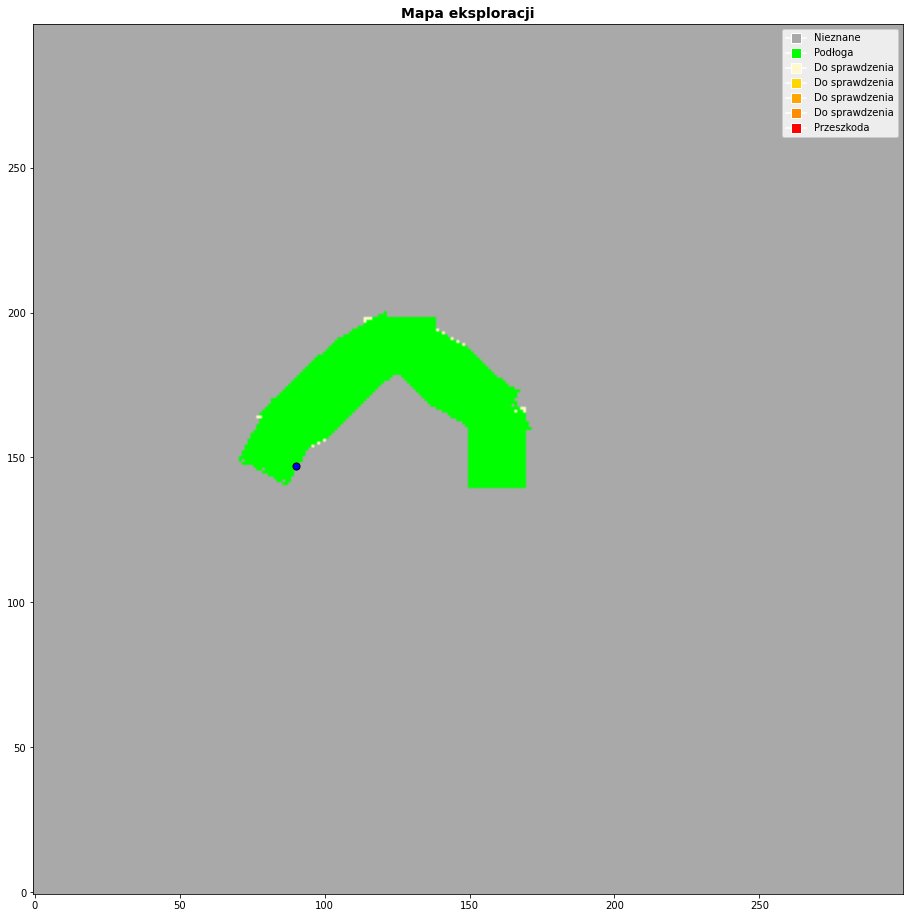

In [18]:
utils.draw_map(robot_x, robot_y, map_grid, MAP_SIZE)

In [30]:
camera.stop()